# Basic Definitions

In [1]:
import numpy as np
import scipy as sci
import scipy.special as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numba as nb
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

vec_norm = np.linalg.norm
det = np.linalg.det
erfc = sp.erfc
twopi = 2.0*np.pi

class Lattice:
    def __init__(self, a1, a2, a3, lat_size=1.0, gvec_normalize=False):
        if det([a1, a2, a3]) == 0.0:
            raise ValueError("Basis vectors are linear dependent!")
        else:
            self.lat_size = lat_size
            self.a1 = np.asarray(a1)*self.lat_size
            self.a2 = np.asarray(a2)*self.lat_size
            self.a3 = np.asarray(a3)*self.lat_size
            self.lat_basis = np.array([self.a1, self.a2, self.a3])
            self.uc_vol = np.abs( det([self.a1, self.a2, self.a3]) )
            if gvec_normalize:
                twopi_o_vol = 1.0
            else:
                twopi_o_vol = twopi/self.uc_vol
            self.b1 = twopi_o_vol*np.cross(self.a2, self.a3)
            self.b2 = twopi_o_vol*np.cross(self.a3, self.a1)
            self.b3 = twopi_o_vol*np.cross(self.a1, self.a2)
            self.reci_basis = np.array([self.b1, self.b2, self.b3])
    
    def lat_vec(self, c1, c2, c3=0.0):
        return c1*self.a1 + c2*self.a2 + c3*self.a3
    
    def reci_vec(self, g1, g2, g3=0.0):
        return g1*self.b1 + g2*self.b2 + g3*self.b3

#   Define a few lattices
# square lattice for Tsang-Kong book examples.
square0=Lattice([0.95, 0, 0], \
                [0, 0.95, 0], \
                [0, 0, 1])

square = Lattice(a1=[1, 0, 0], a2=[0, 1, 0], a3=[0, 0, 1])

triangular = Lattice(a1=[0.5, 0.5*np.sqrt(3), 0], 
                     a2=[0.5, -0.5*np.sqrt(3), 0], 
                     a3=[0, 0, 1])

def gvec(n1, n2, lat):
    return [ lat.reci_vec(g1, g2) 
            for g1 in np.linspace(-n1, n1, 2*n1+1)
            for g2 in np.linspace(-n2, n2, 2*n2+1) ]

def rmesh(nx, ny, lat, rmin=1j, rmax=1e8):
    x = np.arange(-nx, nx+1)
    y = np.arange(-ny, ny+1)
    xs, ys = np.meshgrid(x, y)
    ax, ay = lat.a1, lat.a2
    mask = ( (xs*ax[0])**2 + (ys*ay[1])**2 > rmin**2 ) &\
    ( (xs*ax[0])**2 + (ys*ay[1])**2 < rmax**2 )
    grid = np.tensordot(xs[mask], ax, axes=0) + \
    np.tensordot(ys[mask], ay, axes=0)
    return grid
    
def gmesh(nx, ny, lat, gmin=-1.0, gmax=None):
    gx, gy = lat.b1, lat.b2
    if gmax is None:
        gmax = 1e8
    else:
        scale = 2
        nx = scale*np.int(np.floor(gmax/vec_norm(gx)))
        ny = scale*np.int(np.floor(gmax/vec_norm(gy)))
    x = np.arange(-nx, nx+1)
    y = np.arange(-ny, ny+1)
    xs, ys = np.meshgrid(x, y)
    grid = np.tensordot(xs, gx, axes=0) + \
    np.tensordot(ys, gy, axes=0)
    mask = ( vec_norm(grid, axis=2) > gmin ) &\
    ( vec_norm(grid, axis=2) <= gmax )
    return grid[mask]

def g1term(rvec, kvec, kw, E, g, lat):
    g = np.atleast_2d(g)
    k = np.asarray(kvec)
    r = np.asarray(rvec)
    kz = sci.sqrt(kw**2 - vec_norm(k+g, axis=1)**2)
    z = r[2]
    uc_vol = lat.uc_vol
    return np.pi*1j/uc_vol*np.exp(1j*np.dot(k+g, r))/kz* \
           ( np.exp(1j*kz*z)*erfc(-1j*kz/2.0/E - E*z) + \
            np.exp(-1j*kz*z)*erfc(-1j*kz/2.0/E + E*z) )

def g1_sum(nx, ny, rvec, kvec, kw, E, lat, grid=None):
    if grid is None:
        grid = gmesh(nx, ny, lat)
    return np.sum( g1term(rvec, kvec, kw, E, grid, lat) )

def g2term(rvec, kvec, kw, E, Rvec, lat):
    k = np.asarray(kvec)
    r = np.asarray(rvec)
    R = np.atleast_2d(Rvec)
    eik = np.exp(1j*np.dot(R, k))
    rR = vec_norm(r-R, axis=1)
    ikw2E = 1j*kw/2.0/E
    return 0.5*eik/rR* \
            ( np.exp(1j*kw*rR)*erfc(E*rR + ikw2E) + \
             np.exp(-1j*kw*rR)*erfc(E*rR - ikw2E) )

def g2_sum(nx, ny, rvec, kvec, kw, E, lat, grid=None):
    if grid is None:
        grid = rmesh(nx, ny, lat)
    return np.sum( g2term(rvec, kvec, kw, E, grid, lat) )

def g3(kw, E):
    return - 1.0*1j*kw*erfc(-1j*kw/2.0/E) \
    - 1.0*2*E/np.sqrt(np.pi)*np.exp(kw**2/4.0/E**2)

def S_ewald(k, kw, N_G, N_R, E, lat, c1, c2, c3):
    r0 = [0, 0, 0]
    rs = rmesh(N_R, N_R, lat, rmin=0)
    Gsum = g1_sum(N_G, N_G, r0, k, kw, E, lat)
    Rsum = g2_sum(N_R, N_R, r0, k, kw, E, lat, grid=rs)
    other = - 1.0*1j*kw*erfc(-1j*kw/2.0/E) \
    - 1.0*2*E/np.sqrt(np.pi)*np.exp(kw**2/4.0/E**2)
    return c1*Gsum + c2*Rsum + c3*other

def fRn(Rvec, n):
    '''
    Returns an algebraically decaying potential f(R) = 1/R^n, R=|Rvec|
    '''
    Rvec = np.atleast_2d( Rvec )
    return 1.0/vec_norm(Rvec, axis=1)**n

fR1 = lambda Rvec: fRn(Rvec, 1)
fR2 = lambda Rvec: fRn(Rvec, 2)
fR3 = lambda Rvec: fRn(Rvec, 3)

def Rsum_direct(func, numR, rvec, kvec, kw, lat):
    '''
    numpy vectorized version for direct real-space 
    lattice sum S(k, kw)
    '''
    grid = rmesh(numR, numR, lat, rmin=0)
    terms = np.exp( 1j*np.dot(grid, kvec) ) * \
    np.exp( 1j*kw*vec_norm(rvec - grid, axis=1) ) * func(grid)
    return np.sum(terms)

def plot_grid(grid, marker='o', pointsize=4,\
              if_save=False, filename='grid.pdf'):
    plt.figure(figsize=(6,6))
#     X = [ r[0] for r in grid ]
#     Y = [ r[1] for r in grid ]
    X = grid[:, 0]
    Y = grid[:, 1]
    nx = len(X)
    ny = len(Y)
    plt.plot(X, Y, marker, markersize=pointsize)
    plt.grid('on')
    plt.axis('equal')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(r'${}$ Grid Points'.format(nx))
    plt.tight_layout()
    if if_save:
        plt.savefig(filename)
    plt.show()

def rel_err(x, y):
    return (x - y)/np.fabs(y)

marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                   clip_on=True)

# ################################################
# Comparison of two versions of G-grid generation
# ################################################
# %time grid = gmesh(1000, 1000, square)
# %time grid2 = gvec(1000, 1000, square)
# '''
# CPU times: user 165 ms, sys: 129 ms, total: 294 ms
# Wall time: 324 ms
# CPU times: user 22.8 s, sys: 626 ms, total: 23.4 s
# Wall time: 23.8 s
# '''

# #############################
# Grid function gmesh test
# #############################
# nx, ny = 200, 200
# print(2*(nx+1)*2*(ny+1))
# lat = square
# %time grid = gmesh(nx, ny, lat, gmin=nx/10*vec_norm(lat.b1), \
#                    gmax=nx/2*vec_norm(lat.b1))
# %time plot_grid(grid)

def Ggrid(z, U, lat, scale=2):
    z = np.asarray(z)
    Gmax = U/z
    nx = np.int(np.floor(Gmax/vec_norm(lat.b1)))
    ny = np.int(np.floor(Gmax/vec_norm(lat.b2)))
    nx = scale*nx
    ny = scale*ny
    grid = gmesh(nx, ny, lat, gmin=0.0, gmax=Gmax)
    return grid

def Lsum(z, U, lat):
    Gs = Ggrid(z, U, lat)
    V_G = twopi**2/lat.uc_vol
    G = vec_norm(Gs, axis=1)
    return V_G/twopi*np.sum( np.exp(-G*z)/G )

def f1z(z, U, lat):
    z = np.asarray(z)
    L = Lsum(z, U, lat)
    return np.log( z*L + np.exp(-U) )/z

def f2z(z, U, lat):
    z = np.asarray(z)
    L = Lsum(z, U, lat)
    return L + ( np.exp(-U) - 1.0 )/z

def D_const(U, lat, nz=10):
    zz = np.linspace(0.005, 0.05, nz)
    f1 = [ f1z(z, U, lat) for z in zz ]
    f2 = [ f2z(z, U, lat) for z in zz ]
    d1 = np.polyfit(zz, f1, 1)[-1]
    d2 = np.polyfit(zz, f2, 1)[-1]
    return 0.5*(d1+d2)

def g0term(k, kw, g):
    g = np.atleast_2d(g)
    return 1.0/sci.sqrt(kw**2 - vec_norm(k + g, axis=1)**2) -\
           1.0/vec_norm(g, axis=1)/1.0j
#     return 1.0/sci.sqrt(vec_norm(k + g, axis=1)**2 - kw**2) -\
#            1.0/vec_norm(g, axis=1)

def sumG(k, kw, Gmax, lat):
    grid = Ggrid(1.0, Gmax, lat, scale=2)
    return np.sum( g0term(k, kw, grid) )

def S_simowski(k, kw, Gmax, D, lat):
    sg = twopi*1j/lat.uc_vol*sumG(k, kw, Gmax, lat)
    kz = sci.sqrt(kw**2-np.dot(k, k))
    return D + twopi*1j/lat.uc_vol/kz - 1j*kw + sg

def kpath(k1, k2, nk, end_point=False):
    k1 = np.array(k1)
    k2 = np.array(k2)
    dk = k2 - k1
    ks = [ k1 + ik*dk  for ik in np.linspace(0, 1, nk) ]
    if not end_point:
        ks = ks[:-1]
    return ks

# Simowski-Zhen Method Test

## Displaying the extrapolation process for $D$

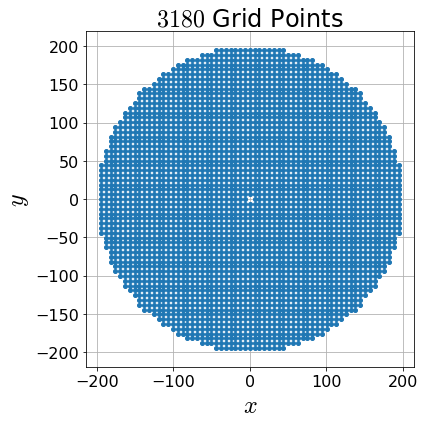

In [4]:
#################################################
#   Displaying the extrapolation process for D
#################################################
lat = square
nz = 10
U = 10.0
zz = np.linspace(0.005, 0.05, nz)
# # Plot the L-sum grid at intermediate z
# z = zz[int(len(zz)/2)]
z0 = 0.05
grid = Ggrid(z0, U, lat)
plot_grid(grid)

Linear fit of f1(z) and f2(z) gives D: D1=-3.9004 and D2=-3.8978
Average D=-3.8991
Deviation with Zhen's D: 2.8646e-04


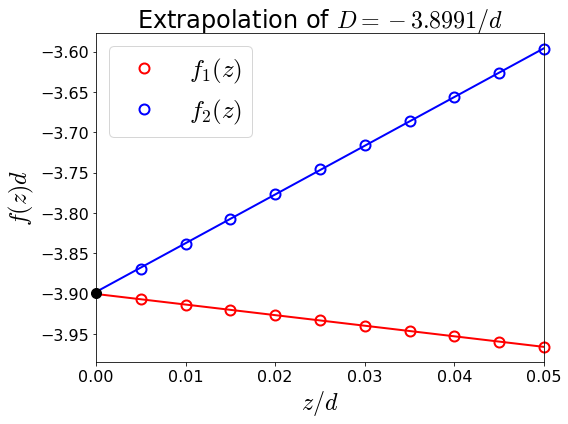

In [5]:
f1 = [ f1z(z, U, lat) for z in zz ]
f2 = [ f2z(z, U, lat) for z in zz ]    
# %time D = D_const(U, lat)
# print('D={:.4f}'.format(D))

# Extrapolate f1 and f2 to z->0 to get D
zz_fit = np.linspace(0, 0.05, 51)
c1 = np.polyfit(zz, f1, 1)
f1_fit = np.poly1d(c1)
d1 = c1[-1]
c2 = np.polyfit(zz, f2, 1)
f2_fit = np.poly1d(c2)
d2 = c2[-1]
D = 0.5*(d1+d2)
print('Linear fit of f1(z) and f2(z) gives D: D1={:.4f} and D2={:.4f}'\
      .format(d1, d2))
print('Average D={:.4f}'.format(0.5*(d1+d2)))
D0 = -3.9002
err = np.abs( ( D - D0 ) / D0 )
print("Deviation with Zhen's D: {:.4e}".format(err))

plt.figure(figsize=(8,6))
plt.plot(zz, f1, 'ro', label='$f_1(z)$', \
         markersize=10, markerfacecolor='None', \
         markeredgewidth=2, clip_on=False)
plt.plot(zz, f2, 'bo', label='$f_2(z)$', \
         markersize=10, markerfacecolor='None', \
         markeredgewidth=2, clip_on=False)
plt.plot(zz_fit, f1_fit(zz_fit), 'r-')
plt.plot(zz_fit, f2_fit(zz_fit), 'b-')
plt.plot(0, 0.5*(d1+d2), 'ko', markersize=10, clip_on=False)
plt.title("Extrapolation of $D={:.4f}/d$".format(0.5*(d1+d2)))
plt.xlim((0, zz[-1]))
plt.xlabel('$z/d$')
plt.ylabel('$f(z)d$')
plt.legend(loc='best', fontsize=25)
plt.tight_layout()
plt.savefig('f1f2.pdf')
plt.show()

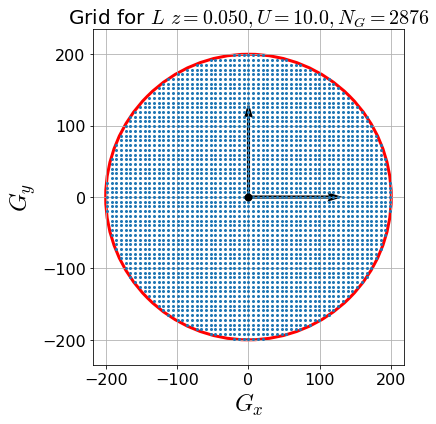

In [9]:
# Plot L-sum Grid
# grid = np.array(Ggrid(1.0, 3*twopi*np.sqrt(2), square0))/twopi
nz = 10
zz = np.linspace(0.005, 0.05, nz)
zz_fit = np.linspace(0, 0.05, 51)
U = 10.0
lat = square0
# lat = triangular
# lat = rectang

z0 = 0.05
U0 = 10
# lat0 = triangular
# lat0 = rectang
grid = np.array(Ggrid(z0, U0, lat))
ng = len(grid[:,0])

g1 = lat.b1
g2 = lat.b2
# print(g1, g2)
origin = [0], [0]

circle = plt.Circle((0, 0), U0/z0, color='r', \
                    fill=False, linewidth=3)
plt.figure(figsize=(6,6))
plt.plot(grid[:,0], grid[:,1], 'o', markersize=2)
plt.plot(0, 0, 'ko', markersize=4, markeredgewidth=4)
plt.axis('equal')
fig = plt.gcf()
ax = fig.gca()
ax.add_artist(circle)
plt.quiver(*origin, g1[0], g1[1], color='k', width=0.01,\
          angles='xy', scale_units='xy', scale=0.05)
plt.quiver(*origin, g2[0], g2[1], color='k', width=0.01,\
          angles='xy', scale_units='xy', scale=0.05)
plt.xlabel('$G_x$')
plt.ylabel('$G_y$')
plt.xlim((-220, 220))
plt.ylim((-220, 220))
plt.axis('equal')
plt.grid('on')
plt.title('Grid for $L$ $z={:.3f},U={:.1f},N_G={}$'\
          .format(z0, U0, ng), fontsize=20)
plt.tight_layout()
plt.savefig('L-grid.pdf')
plt.show()

In [10]:
k = [twopi*0.1, 0, 0]
kw = 0.5*twopi
print(k, kw)
lat = square
Gmax = twopi*160
U = 10.0
D = D_const(U, lat, nz=10)
print('D={:.4f}'.format(D))

%time S_simzhen = S_simowski(k, kw, Gmax, D, lat)
print("S(k, kw) using Simowski-Zhen method: {:.4f}"\
      .format(S_simzhen))

[0.6283185307179586, 0, 0] 3.141592653589793
D=-3.8991
CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 34.3 ms
S(k, kw) using Simowski-Zhen method: -2.5796-1.1004j


## Convergence of Simowski's series

In [11]:
#########################################################################
# Generating a list of Simowski's series with different truncation Gmax
#########################################################################
gmax_list = np.linspace(10, 1000, 10)
%time simos = [ S_simowski(k, kw, Gmax*twopi, D, lat) \
               for Gmax in gmax_list ]

CPU times: user 4.01 s, sys: 2.29 s, total: 6.3 s
Wall time: 6.3 s


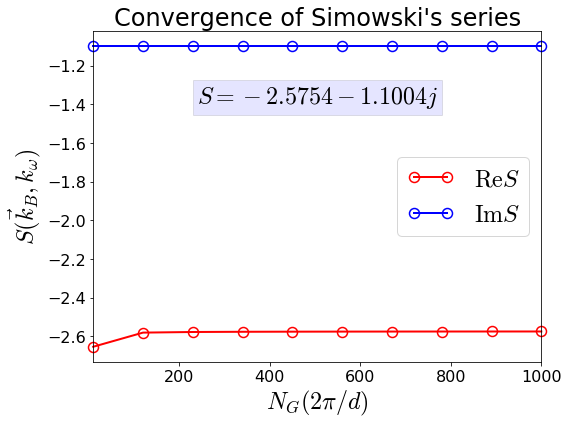

In [12]:
marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                   clip_on=False)
f = plt.figure(figsize=(8,6))
ax = f.add_subplot(111)
plt.plot(gmax_list, np.real(simos), 'ro-', \
         label=r'$\mathrm{Re}S$', **marker_style)
plt.plot(gmax_list, np.imag(simos), 'bo-', \
         label=r'$\mathrm{Im}S$', **marker_style)
plt.xlim((gmax_list[0], gmax_list[-1]))
plt.xlabel(r'$N_G(2\pi/d)$')
plt.ylabel(r'$S({\vec{k}_B, k_{\omega}})$')
plt.title("Convergence of Simowski's series")
plt.legend(loc='best', numpoints=2, fontsize=24)
plt.text(0.5, 0.8, "$S={:.4f}$".format(simos[-1]),\
         horizontalalignment='center',\
         verticalalignment='center',\
         transform=ax.transAxes, \
         bbox=dict(facecolor='blue', alpha=0.1),\
         fontsize=24)
plt.tight_layout()
plt.savefig('simowski-series.pdf')
plt.show()

# Ewald's Method Test

## $G_1$ and $G_2$ Test

E=1.865740895690017
[0.64085638 0.29883624 0.        ]
[0.48, -0.91, 0.0]
G_1 = 0.175+0.460j
G_2 = -0.154-0.011j


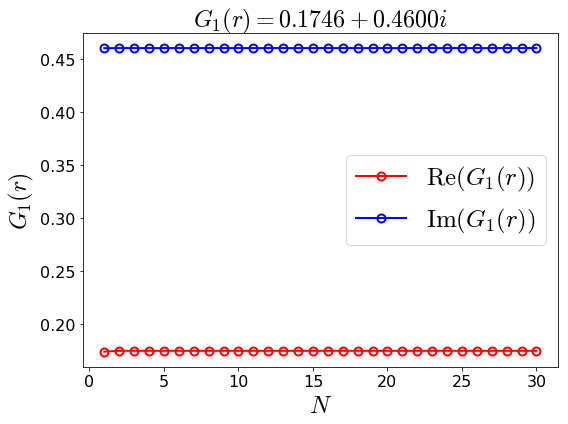

In [13]:
#######################################
#       g1_sum, g2_sum test
#######################################
square0=Lattice([0.95, 0, 0], \
                [0, 0.95, 0], \
                [0, 0, 1])
lat = square0
x, y, z = 0.48, -0.91, 0.0
# x, y, z = 0, 0, 0
k0 = (1.0+0.0j)*twopi
theta, phi = 45/180*np.pi, 25/180*np.pi
kx = np.real(k0)*np.sin(theta)*np.cos(phi)
ky = np.real(k0)*np.sin(theta)*np.sin(phi)
ax, ay = vec_norm(lat.a1), vec_norm(lat.a2)
epara = np.sqrt(np.pi/ax/ay)
print('E=%s'%epara)
kvec = [kx, ky, 0.0]
rvec = [x, y, z]
gvs = gmesh(2, 2, lat)
Rvs = rmesh(2, 2, lat)
print(np.array(kvec)/twopi)
print(rvec)

# G_1
gsum1 = g1_sum(2, 2, rvec, kvec, k0, epara, lat)/4.0/np.pi
print('G_1 = {:.3f}'.format(gsum1))

# G_2
gsum2 = g2_sum(2, 2, rvec, kvec, k0, epara, lat)/4.0/np.pi
print('G_2 = {:.3f}'.format(gsum2))

# G_1 vs N
N = 30
gsumlist = [ g1_sum(N1, N1, rvec, kvec, k0, epara, lat)/4.0/np.pi \
            for N1 in np.arange(1,N+1) ]

# Plot
plt.figure(figsize=(8,6))
plt.plot(range(1,N+1), np.real(gsumlist), 'ro-', \
         label='$\mathrm{Re}(G_1(r))$',
        markersize=8, markerfacecolor="None", markeredgewidth=2)
plt.plot(range(1,N+1), np.imag(gsumlist), 'bo-', \
         label='$\mathrm{Im}(G_1(r))$',
        markersize=8, markerfacecolor="None", markeredgewidth=2)
plt.legend(loc='best',fontsize=25)
plt.xlabel('$N$')
plt.ylabel('$G_1(r)$')
plt.title('$G_1(r)=%5.4f+%5.4fi$' % \
          (np.real(gsumlist[-1]), np.imag(gsumlist[-1])))
plt.tight_layout()
plt.savefig('g1-test.pdf')
plt.show()

## Evolution of $G_i(r)$ with Ewald parameter $E$

E=1.7725


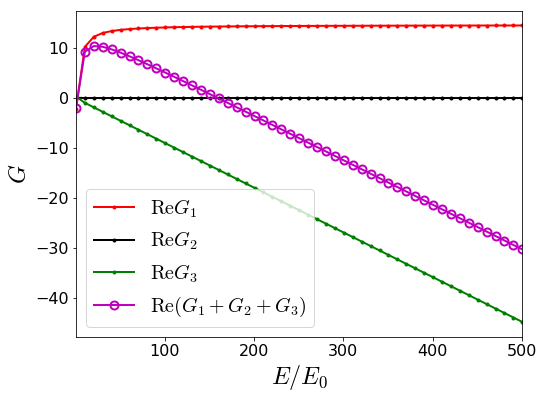

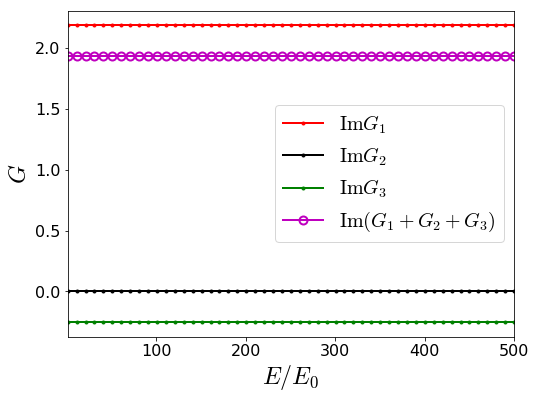

Convergenec of Re(g1s): 1.4004e-04


In [15]:
lat = square
rvec = [0.0, 0, 0]
kvec = [twopi*0.8, 0, 0]
kw = 0.5*twopi
d1 = vec_norm(lat.a1)
d2 = vec_norm(lat.a2)
E_opt = np.sqrt( np.pi * (1.0/d1**2 + 1.0/d2**2) / (d1**2 + d2**2) )
print("E={:.4f}".format(E_opt))

nrx, nry = 2, 2
nkx, nky = 2, 2
rs = rmesh(nrx, nry, lat, rmin=0) #, rmax=100*vec_norm(lat.a1))
gs = gmesh(nkx, nky, lat) #, gmax=100*vec_norm(lat.b1))
# plot_grid(rs)
# plot_grid(gs)
# %time np.sum(g1term(rvec, kvec, kw, E, gs, lat))
# s1 = g1_sum(nx, ny, rvec, kvec, kw, E, lat)
# s2 = g1_sum(None, None, rvec, kvec, kw, E, lat, gs=gs)
# print(np.real((s2 - s1))/np.real(s1), np.imag((s2 - s1))/np.imag(s1))

es = np.linspace(1, 500, 51)
g1s = [ g1_sum(nkx, nky, rvec, kvec, kw, E*E_opt, lat, grid=gs) for E in es]
g2s = [ g2_sum(nrx, nry, rvec, kvec, kw, E*E_opt, lat, grid=rs) for E in es]
g3s = [ g3(kw, E) for E in es]

plt.figure(figsize=(8,6))
plt.plot(es, np.real(g1s), 'ro-', label='$\mathrm{Re}G_1$')
plt.plot(es, np.real(g2s), 'ko-', label='$\mathrm{Re}G_2$')
# plt.plot(es, np.real(g1s)+np.real(g2s), 'bo-', label='$\mathrm{Re}(G_1+G_2)$')
plt.plot(es, np.real(g3s)/4.0/np.pi, 'go-', label='$\mathrm{Re}G_3$')
plt.plot(es, np.real(g1s)+np.real(g2s)+np.real(g3s)/4.0/np.pi,
         'mo-', label='$\mathrm{Re}(G_1+G_2+G_3)$',
         markerfacecolor='None', markersize=8, markeredgewidth=2)
plt.xlabel('$E/E_0$')
plt.ylabel('$G$')
plt.xlim((es.min(), es.max()))
plt.legend(loc=0, fontsize=20)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(es, np.imag(g1s), 'ro-', label='$\mathrm{Im}G_1$')
plt.plot(es, np.imag(g2s), 'ko-', label='$\mathrm{Im}G_2$')
# plt.plot(es, np.imag(g1s)+np.imag(g2s), 'bo-', label='$\mathrm{Im}(G_1+G_2)$')
plt.plot(es, np.imag(g3s)/4.0/np.pi, 'go-', label='$\mathrm{Im}G_3$')
plt.plot(es, np.imag(g1s)+np.imag(g2s)+np.imag(g3s)/4.0/np.pi, \
         'mo-', label='$\mathrm{Im}(G_1+G_2+G_3)$', \
         markerfacecolor='None', markersize=8, markeredgewidth=2)
plt.xlabel('$E/E_0$')
plt.ylabel('$G$')
plt.xlim((es.min(), es.max()))
plt.legend(loc=0, fontsize=20)
plt.show()

deviation = np.abs ( np.real(g1s[-1]) - np.real(g1s[-2]) )/ np.real(g1s[-2])
print("Convergenec of Re(g1s): {:.4e}".format(deviation))

# Comparison of Direct Sum, Simowski-Zhen and Ewald

## Direct Sum Convergence Test

In [16]:
# Test parameters
lat = square
r0 = [0, 0, 0]
kw = twopi*0.5
k = [ twopi*0.8, 0, 0 ]

# Direct summation
# numR = 500
# %time grid = rmesh(numR, numR, lat, rmin=0)
# plot_grid(grid)
# %time Rsum_direct(fR1, numR, [0,0,0], k, kw, lat)

In [17]:
# Convergence of direct summation
Ns = np.arange(30, 3100, 300)
%time Rsums = [ Rsum_direct(fR1, numR, r0, k, kw, lat)\
               for numR in Ns ]

CPU times: user 39.6 s, sys: 13.1 s, total: 52.7 s
Wall time: 45.2 s


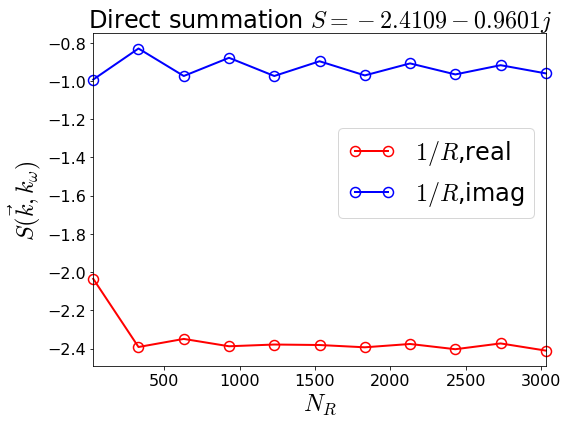

In [18]:
# Plot
marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                   clip_on=False)

plt.figure(figsize=(8,6))
plt.plot(Ns, np.real(Rsums), 'ro-', label=r'$1/R$,real', \
        **marker_style)
plt.plot(Ns, np.imag(Rsums), 'bo-', label=r'$1/R$,imag', \
        **marker_style)
plt.xlim((Ns[0], Ns[-1]))
plt.xlabel('$N_R$')
plt.ylabel(r'$S(\vec{k}, k_{\omega})$')
plt.title("Direct summation $S={:.4f}$".format(Rsums[-1]))
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.75),\
           numpoints=2, fontsize=24)
plt.tight_layout()
plt.savefig('direct-sum.pdf')
plt.show()

## Convergence of Ewald's Method

CPU times: user 144 ms, sys: 184 ms, total: 328 ms
Wall time: 55.6 ms


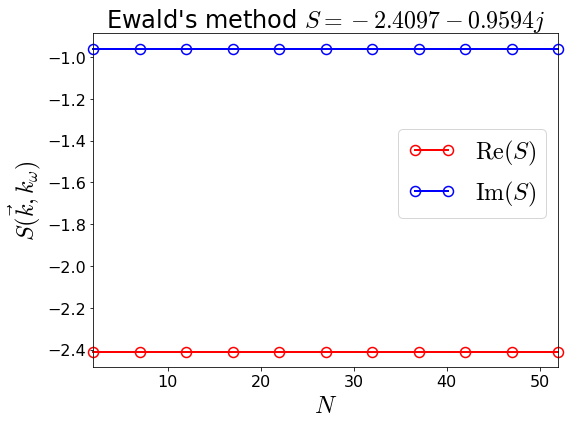

In [19]:
# Convergence test for Ewald's method vs 
ax, ay = vec_norm(lat.a1), vec_norm(lat.a2)
E0 = np.sqrt(np.pi/ax/ay)
E = 1.0
# number of terms
Ns = np.arange(2, 55, 5)
%time S_ewald_N = [ S_ewald(k, kw, n, n, E*E0, lat, 1, 1, 1)\
            for n in Ns]

marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                   clip_on=False)

plt.figure(figsize=(8,6))
plt.plot(Ns, np.real(S_ewald_N), 'ro-', label='$\mathrm{Re}(S)$',\
        **marker_style)
plt.plot(Ns, np.imag(S_ewald_N), 'bo-', label='$\mathrm{Im}(S)$',\
        **marker_style)
plt.xlim((Ns[0], Ns[-1]))
plt.xlabel('$N$')
plt.ylabel(r'$S(\vec{k}, k_{\omega})$')
plt.title("Ewald's method $S={:.4f}$".\
          format(S_ewald_N[-1]))
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.75),\
           numpoints=2, fontsize=24)
plt.tight_layout()
plt.savefig('ewald-convergence.pdf')
plt.show()

## Comparison of Three methods

In [55]:
kw = twopi*0.5
k = [ twopi*0.8, 0, 0 ]

U = 10.0
D = D_const(U, lat, nz=10)

# Direct summation
numR = 1000
%time S_direct = Rsum_direct(fR1, numR, r0, k, kw, lat)
print("Direct summation S: {:.4f}".format(S_direct))

# Direct summation
# numR = 3000
# %time S_direct = Rsum_direct(fR1, numR, r0, k, kw, lat)
# print("Direct summation S: {:.4f}".format(S_direct))

# Ewald
E = 1*np.sqrt(np.pi/vec_norm(lat.a1)/vec_norm(lat.a2))
N_G = 5
N_R = 5
print('E={:.6f}'.format(E))
print('k={}, kw={:.4f}'.format(k, kw))
%time S_Ewald = S_ewald(k, kw, N_G, N_R, 1*E, lat, 1, 1, 1)
print("S(k, kw) using Ewald's method: {:.4f}".format(S_Ewald))

# Simowski
Gmax = 320*np.pi
%time S_simzhen = S_simowski(k, kw, Gmax, D, lat)
print("S(k, kw) using Simowski-Zhen method: {:.4f}"\
      .format(S_simzhen))
# print("S(k, kw) using Simowski-Zhen method: {:.4f}"\
#       .format(simos[-1]))

CPU times: user 1 s, sys: 468 ms, total: 1.47 s
Wall time: 1.44 s
Direct summation S: -2.4076-0.8923j
E=1.772454
k=[5.026548245743669, 0, 0], kw=3.1416
CPU times: user 1.07 ms, sys: 231 µs, total: 1.3 ms
Wall time: 1.12 ms
S(k, kw) using Ewald's method: -2.4097-0.9594j
CPU times: user 62.5 ms, sys: 52.5 ms, total: 115 ms
Wall time: 124 ms
S(k, kw) using Simowski-Zhen method: -2.4197-0.9594j


In [ ]:
# ks = twopi * np.linspace(1e-6, 1.0, 1001)
# %time s0 = [ S_ewald([k, 0, 0], kw, N_G, N_R, 1*E, lat, 1, 1, 1) for k in ks ]

### Evolution of $S(\vec{k}, k_{\omega})$ vs. $k$

In [21]:
kw = 0.1*twopi
nk = 501
ks = twopi * np.linspace(1e-6, 1.0, nk)
ks = twopi * np.linspace(1e-3, 1.8, nk)
s1k = [ S_ewald([k, 0, 0], kw, N_G, N_R, 1*E, lat, 1, 1, 1) for k in ks ]
Gmax = 320*np.pi
s2k = [ S_simowski([k, 0, 0], kw, Gmax, D, lat) for k in ks ]

In [22]:
# Save data
with open('s-k-compare.txt', 'w') as f:
    for k, s1, s2 in zip(ks/twopi, s1k, s2k):
        f.write("{:.6f}\t{:.6f}\t{:.6f} \n".format(k, s1, s2))

# Load and plot
# x, y1, y2 = np.loadtxt('data.txt', dtype=np.complex_).T
# plt.plot(x, np.real(y1), 'ro-')
# plt.plot(x, np.imag(y1), 'go-')
# plt.plot(x, np.real(y2), 'bo-')
# plt.plot(x, np.imag(y2), 'ko-')
# plt.show()

# # Save data using numpy.savetxt
# data = np.array([ks/twopi, s1k, s2k], dtype=object).T
# print(data[0])
# # np.savetxt('s-k-compare.txt', data, fmt='%.4f, %.4f+%.4fj, %.4f+%.4fj')
# # np.savetxt('s-k-compare.txt', data, fmt=['%.4f','%.4f+%.4fj','%.4f+%.4fj'])

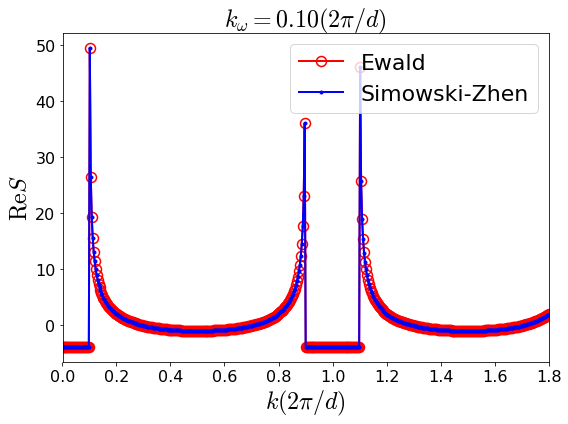

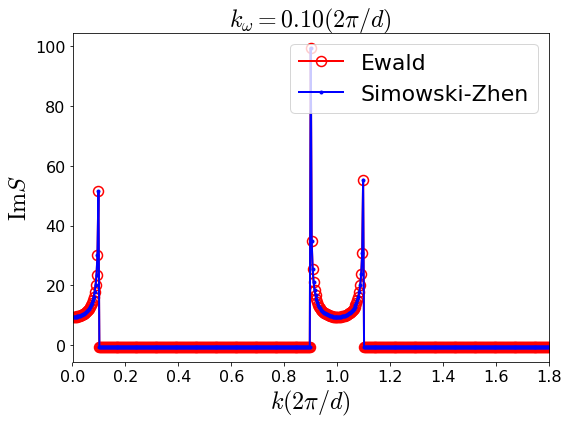

In [23]:
marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                   clip_on=True)

plt.figure(figsize=(8,6))
plt.plot(ks/twopi, np.real(s1k), 'ro-',\
         label='Ewald', **marker_style)
plt.plot(ks/twopi, np.real(s2k), 'bo-',\
        label='Simowski-Zhen')
plt.legend(loc='best', fontsize=22)
plt.xlabel('$k(2\pi/d)$')
plt.ylabel('$\mathrm{Re}S$')
plt.title(r"$k_{\omega}=$"+"${:.2f}(2\pi/d)$".format(kw/twopi))
plt.xlim((ks[0]/twopi, ks[-1]/twopi))
# plt.ylim((-10,30))
plt.tight_layout()
plt.savefig('s-k-compare-real.pdf')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(ks/twopi, np.imag(s1k), 'ro-',\
         label='Ewald', **marker_style)
plt.plot(ks/twopi, np.imag(s2k), 'bo-',\
        label='Simowski-Zhen')
plt.legend(loc='best', fontsize=22)
plt.xlabel('$k(2\pi/d)$')
plt.ylabel('$\mathrm{Im}S$')
plt.title(r"$k_{\omega}=$"+"${:.2f}(2\pi/d)$".format(kw/twopi))
plt.xlim((ks[0]/twopi, ks[-1]/twopi))
# plt.xlim((0.8, 1.0))
# plt.ylim((-100,100))
plt.tight_layout()
plt.savefig('s-k-compare-imag.pdf')
plt.show()

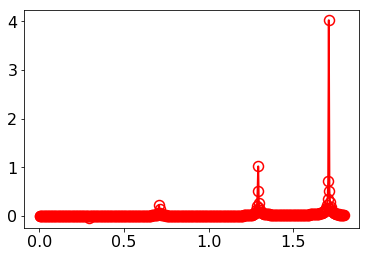

In [24]:
# Plot relative error
plt.plot(ks/twopi, rel_err(np.real(s1k), np.real(s2k)), 'ro-', **marker_style)
# plt.ylim((-1e-1,0))
plt.show()

### Evolution of $S(\vec{k}, k_{\omega})$ vs. $k_{\omega}$

In [25]:
k = [0.3*twopi, 0, 0]
nkw = 501
kws = twopi * np.linspace(1e-6, 1.5, nkw)
%time s1kw = [ S_ewald(k, kw, N_G, N_R, 1*E, lat, 1, 1, 1) for kw in kws ]
Gmax = 320*np.pi
%time s2kw = [ S_simowski(k, kw, Gmax, D, lat) for kw in kws ]

CPU times: user 252 ms, sys: 4 ms, total: 256 ms
Wall time: 257 ms
CPU times: user 14.7 s, sys: 0 ns, total: 14.7 s
Wall time: 14.7 s


In [26]:
# Save data
with open('s-kw-compare.txt', 'w') as f:
    for kw, s1, s2 in zip(kws/twopi, s1kw, s2kw):
        f.write("{:.6f}\t{:.6f}\t{:.6f} \n".format(kw, s1, s2))

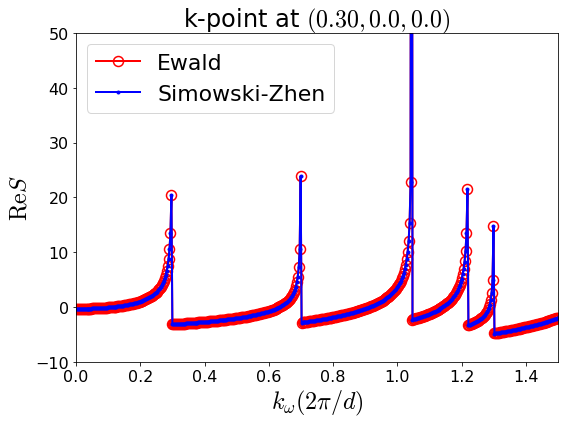

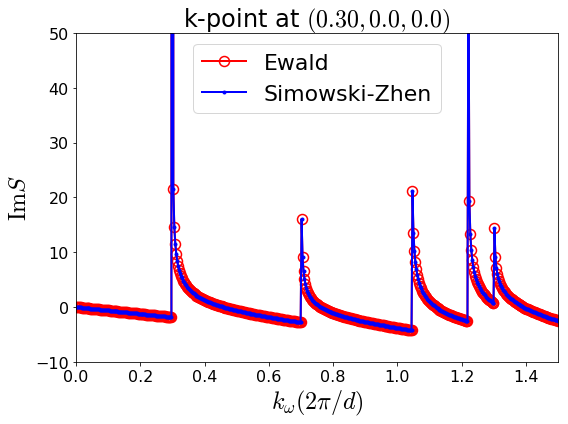

In [27]:
marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                   clip_on=True)

plt.figure(figsize=(8,6))
plt.plot(kws/twopi, np.real(s1kw), 'ro', \
         label='Ewald', **marker_style)
plt.plot(kws/twopi, np.real(s2kw), 'bo-', \
         label='Simowski-Zhen')
plt.legend(loc='best', fontsize=22)
plt.xlabel('$k_{\omega}(2\pi/d)$')
plt.ylabel('$\mathrm{Re}S$')
plt.title('k-point at $({:.2f},{},{})$'.\
          format(k[0]/twopi, k[1]/twopi, k[2]/twopi))
plt.xlim((kws[0]/twopi, kws[-1]/twopi))
plt.ylim((-10,50))
plt.tight_layout()
plt.savefig('s-kw-compare-real.pdf')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(kws/twopi, np.imag(s1kw), 'ro', \
         label='Ewald', **marker_style)
plt.plot(kws/twopi, np.imag(s2kw), 'bo-', \
         label='Simowski-Zhen')
plt.legend(loc='best', fontsize=22)
plt.xlabel('$k_{\omega}(2\pi/d)$')
plt.ylabel('$\mathrm{Im}S$')
plt.title('k-point at $({:.2f},{},{})$'.\
          format(k[0]/twopi, k[1]/twopi, k[2]/twopi))
plt.xlim((kws[0]/twopi, kws[-1]/twopi))
plt.ylim((-10,50))
plt.tight_layout()
plt.savefig('s-kw-compare-imag.pdf')
plt.show()

### $D$ constant evaluation by Ewald's method

In [33]:
def dterm(x):
    x = np.asarray(x)
    return erfc(np.sqrt(np.pi)*x)/x

ns = [1.0, np.sqrt(2.0), 2, np.sqrt(5)]
# print(ns)
print(dterm(ns))
D_ewald = (2*dterm(ns).sum() - 1.0 ) * 4.0

print("D constant by Ewald's method calculated to {:d}th term:{:.6f}"
     .format(len(ns), D_ewald))

[1.21888822e-02 2.77716604e-04 2.67582331e-07 9.31391746e-09]
D constant by Ewald's method calculated to 4th term:-3.900265


# Band Structure

## Quasi-static limit

In [34]:
# fR3 = lambda Rvec: fRn(Rvec, 3)
kw = 0.1*twopi
kvec = [0.11*twopi, 0, 0]
r0 = [0, 0, 0]
nx, ny = 10, 10
lat = square
# grid = rmesh(nx, ny, lat)
# plot_grid(grid)
%time print(Rsum_direct(fR3, nx, r0, kvec, kw, lat))

(3.9148209895754498+3.685834792470989j)
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 726 µs


In [35]:
Ns = np.arange(30, 1000, 100)
%time Rsums = [ Rsum_direct(fR3, numR, r0, kvec, kw, lat)\
               for numR in Ns ]

CPU times: user 4.77 s, sys: 3.86 s, total: 8.63 s
Wall time: 3.89 s


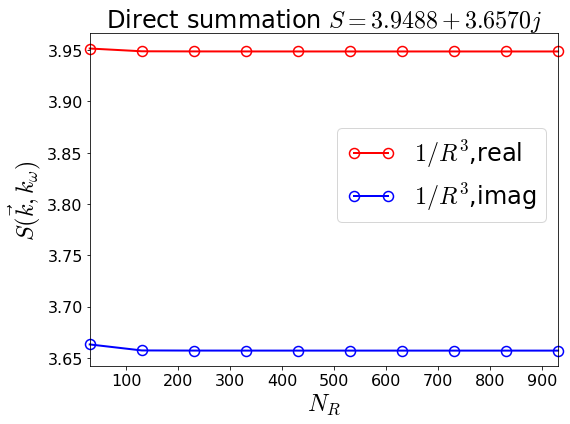

In [36]:
# Plot
marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                   clip_on=False)

plt.figure(figsize=(8,6))
plt.plot(Ns, np.real(Rsums), 'ro-', label=r'$1/R^3$,real', \
        **marker_style)
plt.plot(Ns, np.imag(Rsums), 'bo-', label=r'$1/R^3$,imag', \
        **marker_style)
plt.xlim((Ns[0], Ns[-1]))
plt.xlabel('$N_R$')
plt.ylabel(r'$S(\vec{k}, k_{\omega})$')
plt.title("Direct summation $S={:.4f}$".format(Rsums[-1]))
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.75),\
           numpoints=2, fontsize=24)
plt.tight_layout()
plt.savefig('direct-sum.pdf')
plt.show()

### Comparison of interaction of different range

In [2]:
# Sample calculation for 1/R, 1/R^2 and 1/R^3 lattice sums
r0 = [0, 0, 0]
kvec = [0.3*twopi, 0, 0]
kw = 0.2*twopi
lat_test = square
nums = np.arange(5, 2000, 200)

fR1 = lambda Rvec: fRn(Rvec, 1)
fR2 = lambda Rvec: fRn(Rvec, 2)
fR3 = lambda Rvec: fRn(Rvec, 3)
%time f1 = [ Rsum_direct(fR1, numR, r0, kvec, kw, lat_test) \
      for numR in nums ]
%time f2 = [ Rsum_direct(fR2, numR, r0, kvec, kw, lat_test) \
      for numR in nums ]
%time f3 = [ Rsum_direct(fR3, numR, r0, kvec, kw, lat_test) \
      for numR in nums ]

CPU times: user 13.6 s, sys: 7.8 s, total: 21.4 s
Wall time: 23.7 s
CPU times: user 12.9 s, sys: 7.4 s, total: 20.3 s
Wall time: 21.8 s
CPU times: user 13.3 s, sys: 6.44 s, total: 19.7 s
Wall time: 20 s


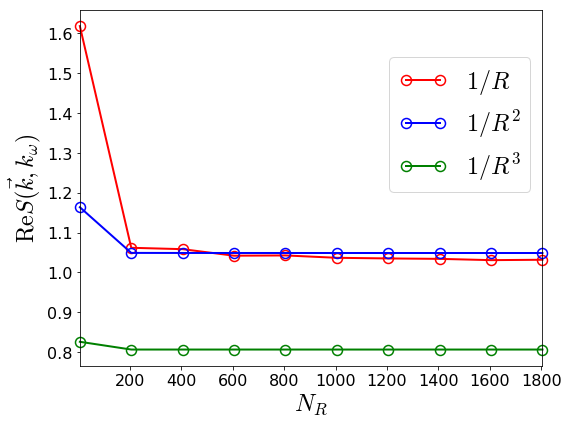

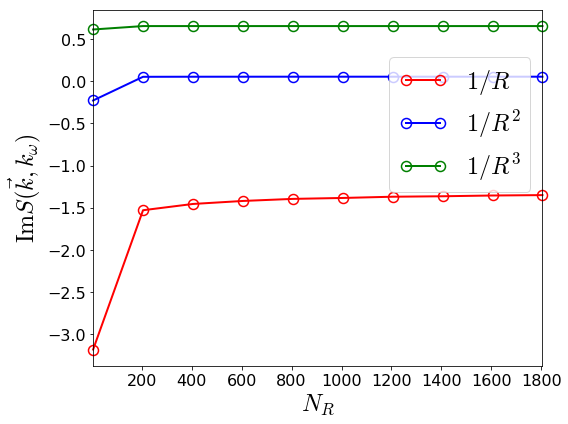

In [3]:
marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                   clip_on=False)

plt.figure(figsize=(8,6))
plt.plot(nums, np.real(f1), 'ro-', label=r'$1/R$', \
        **marker_style)
plt.plot(nums, np.real(f2), 'bo-', label=r'$1/R^2$', \
        **marker_style)
plt.plot(nums, np.real(f3), 'go-', label=r'$1/R^3$', \
        **marker_style)
plt.xlim((nums[0], nums[-1]))
plt.xlabel('$N_R$')
plt.ylabel(r'$\mathrm{Re}S(\vec{k}, k_{\omega})$')
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.9),\
           numpoints=2, fontsize=24)
plt.tight_layout()
plt.savefig('direct-R-sum-real.pdf')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(nums, np.imag(f1), 'ro-', label=r'$1/R$', \
        **marker_style)
plt.plot(nums, np.imag(f2), 'bo-', label=r'$1/R^2$', \
        **marker_style)
plt.plot(nums, np.imag(f3), 'go-', label=r'$1/R^3$', \
        **marker_style)
plt.xlim((nums[0], nums[-1]))
plt.xlabel('$N_R$')
plt.ylabel(r'$\mathrm{Im}S(\vec{k}, k_{\omega})$')
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.9),\
           numpoints=2, fontsize=24)
plt.tight_layout()
plt.savefig('direct-R-sum-imag.pdf')
plt.show()

### Error scaling of direct summation

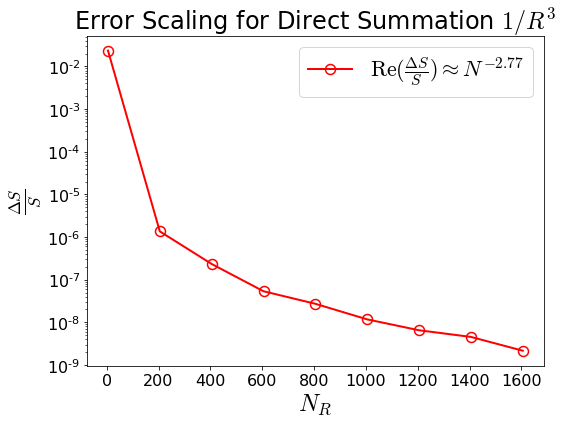

In [4]:
sums = np.array(f3)
err_re = rel_err( sums.real[1:], sums.real[:-1] )
err_im = rel_err( sums.imag[1:], sums.imag[:-1] )

power1, y1 = np.polyfit(np.log(nums[:-1]), np.log(np.fabs(err_re)), 1)
# print(power1, y1)
power2, y2 = np.polyfit(np.log(nums[:-1]), np.log(np.fabs(err_im)), 1)
# print(power2, y2)

label1 = r'$\mathrm{Re}(\frac{\Delta S}{S})$' + \
r'$\approx N^{{ {:.2f} }}$'.format(power1)
label2 = r'$\mathrm{Im}(\frac{\Delta S}{S})$' + \
r'$\approx N^{{ {:.2f} }}$'.format(power2)

plt.rc('text', usetex=False)
plt.rc('font', family='sans')

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.semilogy(nums[:-1], np.fabs(err_re), 'ro-', 
             label=label1, **marker_style)
# plt.semilogy(Ns[:-1], np.power(Ns[:-1], power1)*np.exp(y1), 'ko-')
# plt.semilogy(nums[:-1], np.fabs(err_im), 'bo-',
#              label=label2, **marker_style)
plt.xlabel(r'$N_R$')
plt.ylabel(r'$\frac{\Delta S}{S}$')
plt.title(r'Error Scaling for Direct Summation $1/R^3$')
plt.legend(loc='best', fontsize=22)
# plt.text(0.7, 0.9, \
#          r'$\frac{{\Delta S}}{{S}}\approx N^{{ {:.2f} }}$'.format(power1),\
#          horizontalalignment='center',\
#          verticalalignment='center',\
#          transform=ax.transAxes, \
#          bbox=dict(facecolor='None', alpha=0.1),fontsize=24)
# plt.annotate(r'$\mathrm{Re}(\frac{\Delta S}{S})$'+
#              r'$\approx N^{{ {:.2f} }}$'.format(power1),
#              xy=(0.5, 0.85), xycoords='axes fraction', fontsize=24)
# plt.annotate(r'$\mathrm{Im}(\frac{\Delta S}{S})$'+
#              r'$\approx N^{{ {:.2f} }}$'.format(power2),
#              xy=(0.5, 0.65), xycoords='axes fraction', fontsize=24)
plt.tight_layout()
plt.savefig('direct-sum-error-R3.pdf')
plt.show()

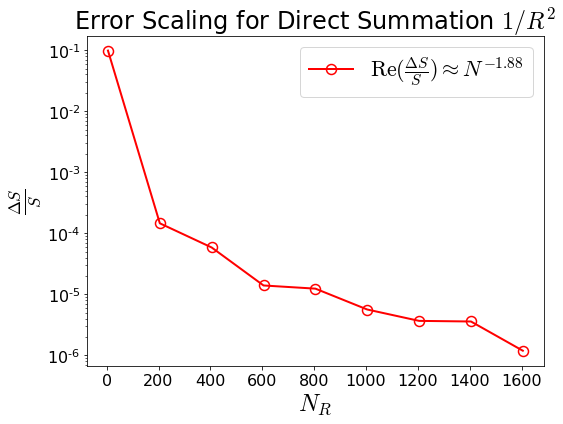

In [5]:
sums = np.array(f2)
err_re = rel_err( sums.real[1:], sums.real[:-1] )
err_im = rel_err( sums.imag[1:], sums.imag[:-1] )

power1, y1 = np.polyfit(np.log(nums[:-1]), np.log(np.fabs(err_re)), 1)
power2, y2 = np.polyfit(np.log(nums[:-1]), np.log(np.fabs(err_im)), 1)

label1 = r'$\mathrm{Re}(\frac{\Delta S}{S})$' + \
r'$\approx N^{{ {:.2f} }}$'.format(power1)
label2 = r'$\mathrm{Im}(\frac{\Delta S}{S})$' + \
r'$\approx N^{{ {:.2f} }}$'.format(power2)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.semilogy(nums[:-1], np.fabs(err_re), 'ro-', 
             label=label1, **marker_style)
# plt.semilogy(Ns[:-1], np.power(Ns[:-1], power1)*np.exp(y1), 'ko-')
# plt.semilogy(nums[:-1], np.fabs(err_im), 'bo-',
#              label=label2, **marker_style)
plt.xlabel(r'$N_R$')
plt.ylabel(r'$\frac{\Delta S}{S}$')
plt.title(r'Error Scaling for Direct Summation $1/R^2$')
plt.legend(loc='best', fontsize=22)
plt.tight_layout()
plt.savefig('direct-sum-error-f2R.pdf')
plt.show()

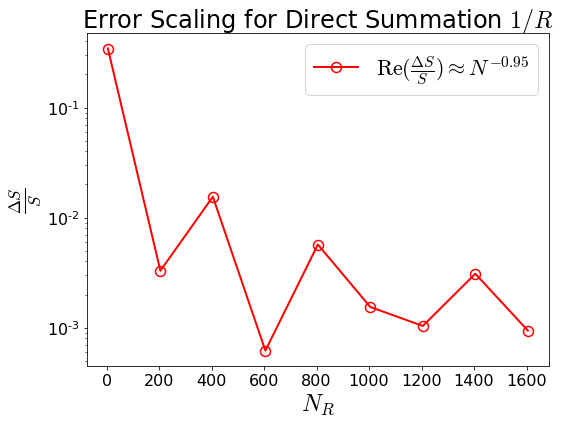

In [6]:
sums = np.array(f1)
err_re = rel_err( sums.real[1:], sums.real[:-1] )
# err_im = rel_err( sums.imag[1:], sums.imag[:-1] )

power1, y1 = np.polyfit(np.log(nums[:-1]), np.log(np.fabs(err_re)), 1)
# power2, y2 = np.polyfit(np.log(nums[:-1]), np.log(np.fabs(err_im)), 1)

label1 = r'$\mathrm{Re}(\frac{\Delta S}{S})$' + \
r'$\approx N^{{ {:.2f} }}$'.format(power1)
# label2 = r'$\mathrm{Im}(\frac{\Delta S}{S})$' + \
# r'$\approx N^{{ {:.2f} }}$'.format(power2)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.semilogy(nums[:-1], np.fabs(err_re), 'ro-', 
             label=label1, **marker_style)
# plt.semilogy(Ns[:-1], np.power(Ns[:-1], power1)*np.exp(y1), 'ko-')
# plt.semilogy(nums[:-1], np.fabs(err_im), 'bo-',
#              label=label2, **marker_style)
plt.xlabel(r'$N_R$')
plt.ylabel(r'$\frac{\Delta S}{S}$')
plt.title(r'Error Scaling for Direct Summation $1/R$')
plt.legend(loc='best', fontsize=22)
plt.tight_layout()
plt.savefig('direct-sum-error-f1R.pdf')
plt.show()

In [118]:
funcR = lambda Rvec: fRn(Rvec, 5)
N1, N2 = 25, 20
%time s1 = Rsum_direct(funcR, N1, r0, kvec, kw, lat_test)
%time s2 = Rsum_direct(funcR, N2, r0, kvec, kw, lat_test)

err1 = np.fabs( rel_err( s1.real, s2.real) )
err2 = np.fabs( rel_err( s1.imag, s2.imag) )
print("Relative error: {:.2e} {:.2e}".format(err1, err2))
abs_err1 = s2.real*err1
abs_err2 = s2.imag*err2
print("Absolute error: {:.2e} {:.2e}"
      .format(abs_err1, abs_err2))

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.65 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 934 µs
Relative error: 7.91e-07 4.98e-06
Absolute error: -1.09e-06 7.28e-07


CPU times: user 13.5 s, sys: 6.35 s, total: 19.9 s
Wall time: 14.7 s


/home/photon7/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:150: RuntimeWarning: divide by zero encountered in true_divide


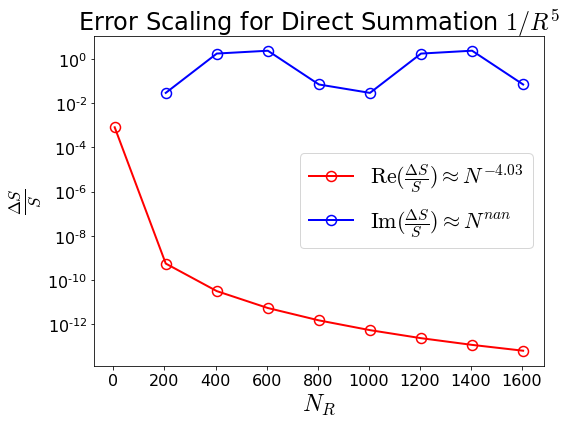

In [166]:
fR5 = lambda Rvec: fRn(Rvec, 5)
%time f5 = [ Rsum_direct(fR5, numR, r0, kvec, kw, lat_test) \
      for numR in nums ]
sums = np.array(f5)
err_re = rel_err( sums.real[1:], sums.real[:-1] )
err_im = rel_err( sums.imag[1:], sums.imag[:-1] )

power1, y1 = np.polyfit(np.log(nums[:-1]), np.log(np.fabs(err_re)), 1)
power2, y2 = np.polyfit(np.log(nums[:-1]), np.log(np.fabs(err_im)), 1)

label1 = r'$\mathrm{Re}(\frac{\Delta S}{S})$' + \
r'$\approx N^{{ {:.2f} }}$'.format(power1)
label2 = r'$\mathrm{Im}(\frac{\Delta S}{S})$' + \
r'$\approx N^{{ {:.2f} }}$'.format(power2)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.semilogy(nums[:-1], np.fabs(err_re), 'ro-', 
             label=label1, **marker_style)
# plt.semilogy(Ns[:-1], np.power(Ns[:-1], power1)*np.exp(y1), 'ko-')
plt.semilogy(nums[:-1], np.fabs(err_im), 'bo-',
             label=label2, **marker_style)
plt.xlabel(r'$N_R$')
plt.ylabel(r'$\frac{\Delta S}{S}$')
plt.title(r'Error Scaling for Direct Summation $1/R^5$')
plt.legend(loc='best', fontsize=22)
plt.tight_layout()
plt.savefig('direct-sum-error-f5R.pdf')
plt.show()

In [167]:
def fnRij(Rvec, n, i, j):
    i, j = int(i), int(j)
    assert 0<= i < 3, "i should be 0, 1, 2"
    assert 0<= j < 3, "j should be 0, 1, 2"
    Rvec = np.atleast_2d( Rvec )
    Ri = Rvec[:, i]
    Rj = Rvec[:, j]
    R = vec_norm(Rvec, axis=1)
    return Ri*Rj/np.power(R, n+2)

In [168]:
r0 = [0, 0, 0]
kvec = [0.3*twopi, 0, 0]
kw = 0.0*twopi
lat_test = square
nums = np.arange(5, 2000, 200)

fR3xy = lambda Rvec: fnRij(Rvec, 3, 0, 1)
%time f3xy = [ Rsum_direct(fR3xy, numR, r0, kvec, kw, lat)\
               for numR in nums ]

CPU times: user 13.5 s, sys: 6.32 s, total: 19.8 s
Wall time: 14.7 s


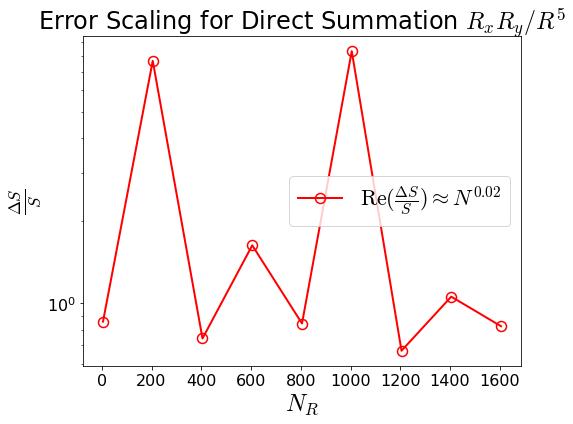

In [170]:
sums = np.array(f3xy)
err_re = rel_err( sums.real[1:], sums.real[:-1] )
# err_im = rel_err( sums.imag[1:], sums.imag[:-1] )

power1, y1 = np.polyfit(np.log(nums[:-1]), np.log(np.fabs(err_re)), 1)
# power2, y2 = np.polyfit(np.log(nums[:-1]), np.log(np.fabs(err_im)), 1)

label1 = r'$\mathrm{Re}(\frac{\Delta S}{S})$' + \
r'$\approx N^{{ {:.2f} }}$'.format(power1)
# label2 = r'$\mathrm{Im}(\frac{\Delta S}{S})$' + \
# r'$\approx N^{{ {:.2f} }}$'.format(power2)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.semilogy(nums[:-1], np.fabs(err_re), 'ro-', 
             label=label1, **marker_style)
# plt.semilogy(nums[:-1], np.fabs(err_im), 'bo-',
#              label=label2, **marker_style)
plt.xlabel(r'$N_R$')
plt.ylabel(r'$\frac{\Delta S}{S}$')
plt.title(r'Error Scaling for Direct Summation $R_xR_y/R^5$')
plt.legend(loc='best', fontsize=22)
plt.tight_layout()
plt.savefig('direct-sum-error-fR3_xy.pdf')
plt.show()

In [194]:
kvec_mirror = [kvec[1], kvec[0], 0]

In [195]:
fR3xy = lambda Rvec: fnRij(Rvec, 3, 0, 1)
fR3yx = lambda Rvec: fnRij(Rvec, 3, 1, 0)
fR3xx = lambda Rvec: fnRij(Rvec, 3, 0, 0)
fR3yy = lambda Rvec: fnRij(Rvec, 3, 1, 1)
fxy = Rsum_direct(fR3xy, 100, r0, kvec, 0, lat)
fyx = Rsum_direct(fR3xy, 100, r0, kvec, 0, lat)
fxx = Rsum_direct(fR3xx, 100, r0, kvec, 0, lat)
fyy = Rsum_direct(fR3yy, 100, r0, kvec, 0, lat)
fyy_mirror = Rsum_direct(fR3yy, 100, r0, kvec_mirror, 0, lat)
fr = Rsum_direct(fR3, 100, r0, kvec, 0, lat)
# print(fxx+fyy, fr, fxx+fyy-fr)
print(fxx, fyy_mirror, fxx-fyy_mirror)

(-1.1807174256624924-3.753176519504203e-17j) (-1.1807174256624924+4.672911363412524e-16j) -5.048229015362944e-16j


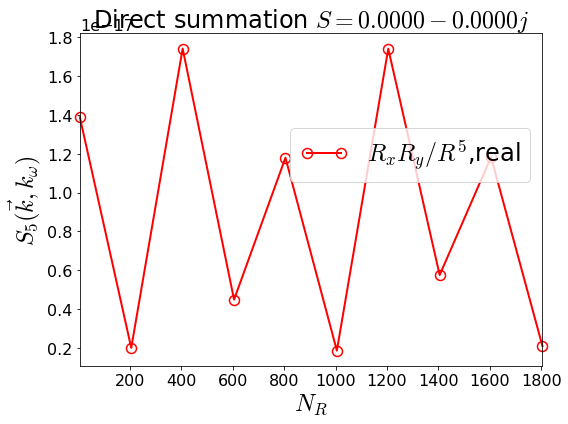

In [171]:
# Plot
marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                   clip_on=False)

plt.figure(figsize=(8,6))
plt.plot(nums, np.real(f3xy), 'ro-', label=r'$R_xR_y/R^5$,real', \
        **marker_style)
# plt.plot(nums, np.imag(f3xy), 'bo-', label=r'$R_xR_y/R^5$,imag', \
#         **marker_style)
plt.xlim((nums[0], nums[-1]))
plt.xlabel('$N_R$')
plt.ylabel(r'$S_5(\vec{k}, k_{\omega})$')
plt.title("Direct summation $S={:.4f}$".format(f3xy[-1]))
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.75),\
           numpoints=2, fontsize=24)
plt.tight_layout()
plt.savefig('direct-sum-R3xy.pdf')
plt.show()

In [ ]:
# Rsum_direct(fR3, numR, r0, kvec, kw, lat)
def diff_S_k(kvec, udk, dk, kw, lat, N_R, sum_func):
    kvec = np.array(kvec)
    udk = np.array(udk)
#     uk = kvec/vec_norm(kvec)
#     return udk
    k1, k2 = kvec - dk/2.0*udk, kvec + dk/2.0*udk
    s1 = Rsum_direct(sum_func, N_R, [0, 0, 0], k1, kw, lat)
    s2 = Rsum_direct(sum_func, N_R, [0, 0, 0], k2, kw, lat)
    return ( s2 - s1 ) / dk

In [ ]:
dk = 1e-4
kvec = [0.11*twopi, 0, 0]
kvec = [0.11*twopi, 0.11*twopi, 0]
udk = [1, 0, 0]
kw = 0.1*twopi
N_R = 300
fR3 = lambda Rvec: fRn(Rvec, 3)

%time diff_S_k(kvec, udk, dk, kw, lat, N_R, fR3)

In [ ]:
dsdk1 = diff_S_k(kvec, udk, dk, kw, lat, 100, fR3)
dsdk2 = diff_S_k(kvec, udk, dk, kw, lat, 300, fR3)

In [ ]:
rel_err(dsdk1.real, dsdk2.real), rel_err(dsdk1.imag, dsdk2.imag)

### Transverse Mode

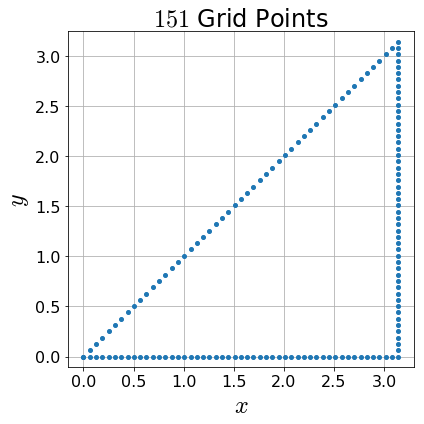

CPU times: user 20.3 s, sys: 36 s, total: 56.3 s
Wall time: 7.29 s
CPU times: user 21 s, sys: 35.8 s, total: 56.8 s
Wall time: 7.34 s
CPU times: user 21 s, sys: 36.6 s, total: 57.6 s
Wall time: 7.39 s
CPU times: user 20.6 s, sys: 36.3 s, total: 56.9 s
Wall time: 7.32 s


In [405]:
# Define high-symmetry k-points
Gamma = lat.reci_vec(0, 0, 0)
X = lat.reci_vec(0.5, 0, 0)
M = lat.reci_vec(0.5, 0.5, 0)

# Generate a Gamma-X-M-Gamma k-vector list
nk = 51
kmesh = np.concatenate([kpath(Gamma, X, nk),\
                       kpath(X, M, nk),\
                       kpath(M, Gamma, nk, end_point=True)])
k_index = np.arange(len(kmesh))
plot_grid(kmesh)

# parameters
a_o_d = 1.0/3.0
kw = 0.0
N_R_z = 200
N_R_xy = 200

# Transverse mode(p_z dipole mode)
%time beta_z = -np.real( [ Rsum_direct(fR3, N_R_z, r0, kvec, kw, lat)\
                         for kvec in kmesh ] )
w_T = np.sqrt( 1.0 - a_o_d**3*beta_z )

# In-plane mode
fR3yx = lambda Rvec: fnRij(Rvec, 3, 1, 0)
fR3xx = lambda Rvec: fnRij(Rvec, 3, 0, 0)
fR3yy = lambda Rvec: fnRij(Rvec, 3, 1, 1)

%time beta_11 = np.array( [ Rsum_direct(fR3xx, N_R_xy, r0, kvec, kw, lat)\
                     for kvec in kmesh ] )
beta_11 = 3.0*beta_11 + beta_z

%time beta_22 = np.array( [ Rsum_direct(fR3yy, N_R_xy, r0, kvec, kw, lat)\
                     for kvec in kmesh ] )
beta_22 = 3.0*beta_22 + beta_z

%time beta_21 = np.array( [ Rsum_direct(fR3yx, N_R_xy, r0, kvec, kw, lat)\
                     for kvec in kmesh ] )

w_TI = 1.0 - a_o_d**3/2.0*\
( beta_11 + beta_22 + np.sqrt( (beta_11 - beta_22)**2 + 4.0*beta_21**2 ) )
w_LI = 1.0 - a_o_d**3/2.0*\
( beta_11 + beta_22 - np.sqrt( (beta_11 - beta_22)**2 + 4.0*beta_21**2 ) )
w_TI = np.sqrt(np.real(w_TI))
w_LI = np.sqrt(np.real(w_LI))

# w_T_raw, w_TI_raw, w_LI_raw = w_T, w_TI, w_LI

# Save band data
# np.savetxt('band-sqaure-qsa-NR-100.txt',
#            np.c_[w_T_raw, w_TI_raw, w_LI_raw],
#            fmt='%.6f', header='T \t TI \t LI',
#            comments='nk={:d}\n'.format(nk))
np.savetxt('band-sqaure-qsa-Nz-{}-Nxy-{}.txt'.format(N_R_z, N_R_xy),
           np.c_[w_T, w_TI, w_LI],
           fmt='%.6f', header='T \t TI \t LI',
           comments='nk={:d}\n'.format(nk))

In [406]:
# Relative error test for N_R=100 and N_R=1000.
# relative error <= 5*10^(-5)
# Large deviation happens at Gamma point since 
# exp(ikR) is 1 and the error is N_R sensitive.

# x = np.loadtxt('band-sqaure-qsa-NR-100.txt', skiprows=2)
# x1, x2, x3 = np.transpose(x)
# y = np.loadtxt('band-sqaure-qsa-NR-1000.txt', skiprows=2)
# y1, y2, y3 = np.transpose(y)
# err1 = rel_err( x3, y3 )
# np.fabs(err1).min(), np.fabs(err1).max()
# most_dev = np.argmax(np.fabs(err1))
# print(most_dev, x1[most_dev], y1[most_dev])
# tol = 4e-6
# np.where(np.fabs(err1) > tol)[0]

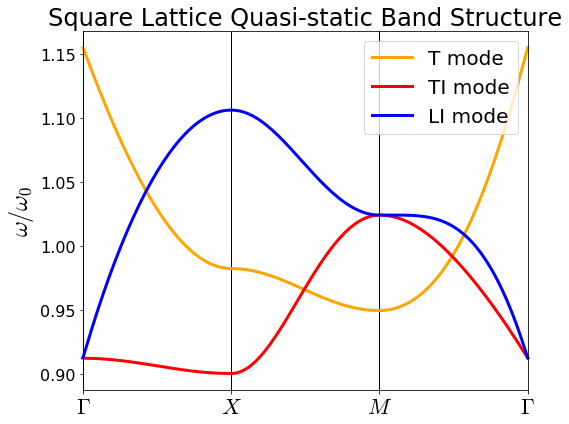

In [407]:
marker_style = dict(linestyle='-', lw=3, marker='', \
                    markersize=5, #markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                    clip_on=False)

hi_sym_k = [0, nk-1, 2*nk-2, -1]
hi_sym_k = k_index[hi_sym_k]
k_labels = ['$\Gamma$', '$X$', '$M$', '$\Gamma$']

plt.figure(figsize=(8,6))

# plt.plot(  k_index, w_T_raw, 'k-', lw=2, label='T mode'  )
# plt.plot( k_index, np.real(w_TI_raw), 'k-', lw=2, label='TI mode' )
# plt.plot( k_index, np.real(w_LI_raw), 'k-', lw=2, label='LI mode' )

plt.plot(  k_index, w_T, 'o', color='orange', **marker_style, label='T mode'  )
plt.plot( k_index, np.real(w_TI), 'ro', **marker_style, label='TI mode' )
plt.plot( k_index, np.real(w_LI), 'bo', **marker_style, label='LI mode' )
plt.xlim((0, len(w)-1))
axes = plt.gca()
ymin, ymax = axes.get_ylim()
# ymin, ymax = 0.85, 1.2
plt.ylim((ymin, ymax))
plt.xticks( hi_sym_k, k_labels, fontsize=22 )
plt.vlines(hi_sym_k, ymin, ymax, lw=1, color='k')
# plt.xlabel(r'$k(\frac{2\pi}{d})$')
plt.ylabel(r'$\omega/\omega_0$')
plt.title('Square Lattice Quasi-static Band Structure')
plt.legend(loc='best', fontsize=20)
plt.tight_layout()
plt.savefig('band-qs-square.pdf')
plt.show()

### Triangular Lattice

## Dynamical Response

In [265]:
hbar = 6.626*10**(-34)/twopi
ev = 1.6*10**(-19)
c0 = 2.99792458*10**8
nm = 10**(-9)
# print(hbar, ev, c0, nm)

def eps_drude(w):
    w_pl = 11.34
    eps_a, eps_b, gamma = 5.45, 6.18, 0.05
    return eps_a - ( eps_b - eps_a )*w_pl**2 / w / (w + 1j*gamma)

def ev2kw( w, d ):
    return w*ev/hbar/c0/(twopi/d)

def kw2ev( kw, d ):
    return kw*twopi/d*c0*hbar/ev

# ev2kw(4.0, 75*nm)
# kw2ev( 0.25, 100*nm )

def alpha(kw, eps_func, a=25*nm, a_o_d=1.0/3.0, unit='twopi/d', rad_corr=True):
    eps = eps_func(kw)
    if unit == 'twopi/d':
        w = kw
    elif unit == 'eV':
        d = a / a_o_d
#         w = ev2kw( kw, d )
        w = kw*ev/hbar
    else:
        raise ValueError(r"Unit input is '{}'. ".format(unit)+\
                         r"Unit for kw must be 'twopi/d' or 'eV'!")
    pol = ( eps - 1.0 ) / ( eps + 2.0 ) * a**3
    if rad_corr:
        pol_inv = 1.0/pol - 1j*2.0/3.0*( w/c0 )**3
        pol = 1.0 / pol_inv
#         pol = 1.0 / ( 1.0/pol - 1j*2.0/3.0*( w*a_o_d*twopi )**3 )
    return pol

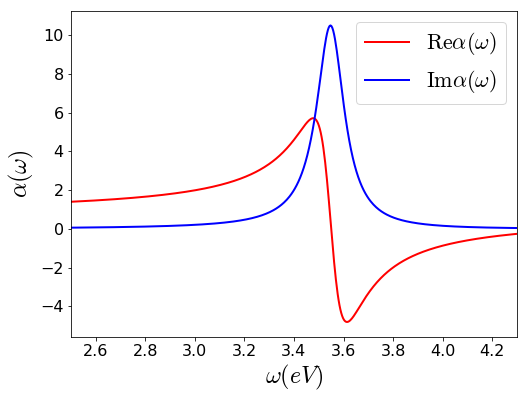

In [243]:
ws = np.linspace(2.5, 4.3, 501)
epsw = eps_drude(ws)
epsw = (epsw - 1)/(epsw+2)
epsr = np.real(epsw)
epsi = np.imag(epsw)
pol = alpha(ws, eps_drude, unit='eV', rad_corr=True)/a**3
polr, poli = pol.real, pol.imag
# pol_no_cor = alpha(ws, eps_drude, unit='eV', rad_corr=False)
# pol_no_r, pol_no_i = pol_no_cor.real, pol_no_cor.imag

plt.figure(figsize=(8,6))
# plt.plot(ws, epsr, 'ro-', label='$\mathrm{Re}\epsilon(\omega)$')
# plt.plot(ws, epsi, 'bo-', label='$\mathrm{Im}\epsilon(\omega)$')
plt.plot(ws, polr, 'r-', label=r'$\mathrm{Re}\alpha(\omega)$')
plt.plot(ws, poli, 'b-', label=r'$\mathrm{Im}\alpha(\omega)$')
axes = plt.gca()
ymin, ymax = axes.get_ylim()
# plt.vlines(3.57, ymin, ymax, color='k', linestyles='dashed')
# plt.plot(ws, pol_no_r, 'k-', label='$\mathrm{Re}\alpha(\omega)$')
# plt.plot(ws, pol_no_i, 'k--', label='$\mathrm{Im}\alpha(\omega)$')
plt.xlabel(r'$\omega(eV)$')
plt.ylabel(r'$\alpha(\omega)$')
plt.legend(loc='best', fontsize=22)
plt.xlim(ws[0], ws[-1])
plt.ylim(ymin, ymax)
plt.show()

### $p_z$ mode
$$
\beta_z = k_{\omega}^2 S_1 + ik_{\omega} S_2 - S_3
$$
where
$$
S_{\alpha} = 
\sum_{\vec{R}\neq \vec{0}} e^{i\vec{k}\cdot\vec{R}}
\frac{e^{i k_{\omega} R}}{R^{\alpha}}
\quad \alpha=1, 2, 3
$$

In [283]:
lat = square
Gamma = lat.reci_vec(0, 0, 0)
X = lat.reci_vec(0.5, 0, 0)
nw = 101
d = 75*nm
a_o_d = 1.0/3.0
a = d*a_o_d
# nk = 31
w_min, w_max = 2.5, 4.3
ws = np.linspace(kw_min, kw_max, nw)
kws = ev2kw(ws, d)*twopi
# print(kws[0], kws[-1])

kvec = [ 0.19, 0, 0 ]

N_R_z = 200
r0 = [0, 0, 0]
E = 1*np.sqrt(np.pi/vec_norm(lat.a1)/vec_norm(lat.a2))
N_G = 5
N_R = 5
%time s1 = np.array( [ S_ewald(kvec, kw, N_G, N_R, E, lat, 1, 1, 1) \
                      for kw in kws ] )
%time s2 = np.array( [ Rsum_direct(fR2, N_R_z, r0, kvec, kw, lat) \
                      for kw in kws ] )
%time s3 = np.array( [ Rsum_direct(fR3, N_R_z, r0, kvec, kw, lat) \
                      for kw in kws ] )

CPU times: user 62 ms, sys: 1.61 ms, total: 63.6 ms
Wall time: 62.3 ms
CPU times: user 6.21 s, sys: 1.63 s, total: 7.84 s
Wall time: 5.36 s
CPU times: user 7.23 s, sys: 1.8 s, total: 9.03 s
Wall time: 5.25 s


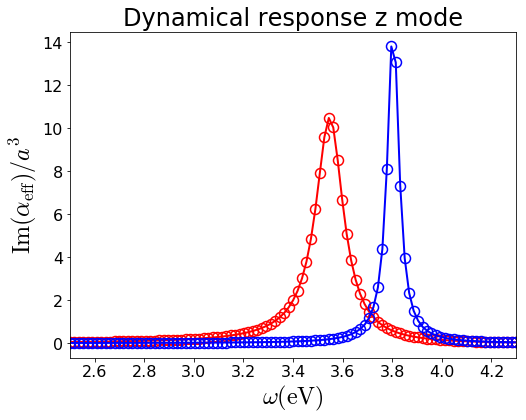

In [284]:
beta_z = kws**2*s1 + 1j*kws*s2 - s3
pol = alpha(ws, eps_drude, a=a, a_o_d=a_o_d, 
            unit='eV', rad_corr=True)
Mz = 1*1.0/pol - 1*beta_z/d**3

plt.figure(figsize=(8,6))
plt.plot(ws, np.imag(pol)/a**3, 'ro-', **marker_style)
plt.plot(ws, np.imag(1.0/Mz)/a**3, 'bo-', **marker_style)
# plt.plot(ws, np.imag(-1/beta_z/a_o_d**3), 'ro-', **marker_style)
plt.xlim(ws[0], ws[-1])
plt.xlabel(r'$\omega(\mathrm{eV})$')
plt.ylabel(r'$\mathrm{Im}(\alpha_{\mathrm{eff}})/a^3$')
plt.title('Dynamical response z mode')
plt.show()

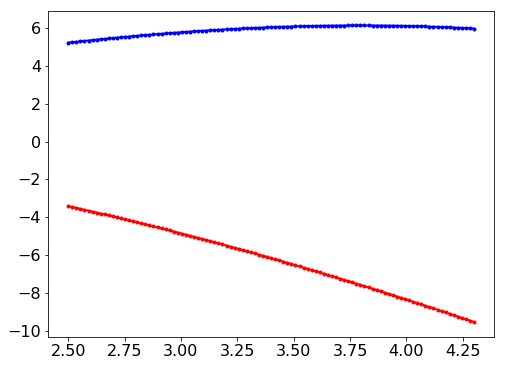

In [285]:
plt.figure(figsize=(8,6))
plt.plot(ws, np.real(kws**2*s1), 'ro-')
plt.plot(ws, np.imag(kws**2*s1), 'bo-')
plt.show()

In [313]:
lat = square
Gamma = lat.reci_vec(0, 0, 0)
X = lat.reci_vec(0.5, 0, 0)
nw = 101
d = 75*nm
a_o_d = 1.0/3.0
a = d*a_o_d
nk = 101
w_min, w_max = 2.5, 4.3
ws = np.linspace(kw_min, kw_max, nw)
kws = ev2kw(ws, d)*twopi
# print(kws[0], kws[-1])

kmesh = kpath(Gamma, X, nk, end_point=True)

ks = np.arange(nk)
kgrid, wgrid = np.meshgrid( ks, ws )
x = np.array( [ [ (y,z) for y in ws ] for z in ks ] )
%time s1 = np.array( [ [ kw**2*S_ewald(kvec, kw, N_G, N_R, E, lat, 1, 1, 1) \
                        for kw in kws ] for kvec in kmesh  ] )

pols = np.array([ [ alpha(w, eps_drude, a=a, a_o_d=a_o_d, 
                          unit='eV', rad_corr=True) 
                   for w in ws] for kvec in kmesh ] )

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)
alpha_eff = 1.0/(1.0/pols - 1*s1/d**3) / a**3
im = ax.pcolormesh(kgrid, wgrid, np.imag(alpha_eff.T), 
                   cmap='RdBu_r', shading='gouraud')
fig.colorbar(im)
plt.xlabel(r'$k(2\pi/d)$')
plt.ylabel(r'$\omega(\mathrm{eV})$')
plt.show()

In [ ]:
N_R_z = 50
r0 = [0, 0, 0]
E = 1*np.sqrt(np.pi/vec_norm(lat.a1)/vec_norm(lat.a2))
N_G = 5
N_R = 5
pols = alpha(ws, eps_drude, a=a, a_o_d=a_o_d, 
             unit='eV', rad_corr=True)
%time s1 = np.array( [ [ kw**2*S_ewald(kvec, kw, N_G, N_R, E, lat, 1, 1, 1) \
                        for kw in kws ] for kvec in kmesh  ] )
%time s2 = np.array( [ [ 1j*kw*Rsum_direct(fR2, N_R_z, r0, kvec, kw, lat) \
                        for kw in kws ] for kvec in kmesh  ] )
%time s3 = np.array( [ [ -Rsum_direct(fR3, N_R_z, r0, kvec, kw, lat) \
                        for kw in kws ] for kvec in kmesh  ] )
beta_z = s1 + s2 + s3

Mz = 1.0/pols - beta_z/d**3

import matplotlib.colors as colors
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)
alpha_eff = 1.0/Mz / a**3
Z = np.imag(alpha_eff.T)
im = ax.pcolormesh(kgrid, wgrid, Z, 
                   vmin = 0, vmax = 35,
#                    norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
                   cmap='RdBu_r', shading='gouraud')
fig.colorbar(im)
plt.xlabel(r'$k(2\pi/d)$')
plt.ylabel(r'$\omega(\mathrm{eV})$')
plt.tight_layout()
plt.savefig('T-mode-dynamical.pdf')
plt.show()